In [ ]:
# %pip install latex 
# %pip install SciencePlots

In [1]:
import os
from tqdm.auto import tqdm 
import os.path as op
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import scienceplots
import pylab as pl

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["figure.autolayout"] = True
plt.style.use(["science", "nature", "no-latex"])

c:\Anaconda3\envs\ecg\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Anaconda3\envs\ecg\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Anaconda3\envs\ecg\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def get_sensitivity_specificity(label_list, prediction_list):
    cm = confusion_matrix(label_list, prediction_list)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    return sensitivity, specificity

def get_sensitivity_and_specificity_by_threshold(
    label_list,
    predicted_proba_list,
    threshold_list = np.arange(0, 1.01, 0.01)
    ):
    sensitivity_list = []
    specificity_list = []
    for threshold in threshold_list:
        predicted_list = []
        for proba in predicted_proba_list:
            prediction = 1 if proba >= threshold else 0
            predicted_list.append(prediction)

        sensitivity, specificity = get_sensitivity_specificity(label_list, predicted_list)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
    return sensitivity_list, specificity_list

def get_sensitivity_specificity_table(
    dataframe,
    label_column_name: str = "label",
    predicted_proba_column_name: str = "proba",
    target_sensitivity_list: list = [0.8, 0.9, 0.95, 0.99],
    threshold_list = np.arange(0, 1.01, 0.01),
    ):
    dataframe = dataframe.copy()
    label_list = list(dataframe[label_column_name])
    predicted_proba_list = list(dataframe[predicted_proba_column_name])

    sensitivity_list, specificity_list = get_sensitivity_and_specificity_by_threshold(
        label_list,
        predicted_proba_list,
        threshold_list = threshold_list
    )

    sensitivity_to_specificity_dictionary = {}
    for target_sensitivity in target_sensitivity_list:
        index = np.argmin(np.abs(np.array(sensitivity_list) - target_sensitivity))
        sensitivity_to_specificity_dictionary[target_sensitivity] = specificity_list[index]

    sensitivity_to_specificity_dataframe = pd.DataFrame.from_dict(sensitivity_to_specificity_dictionary, orient="index")
    sensitivity_to_specificity_dataframe.columns = ["Specificity"]

    # Move the index (Sensitivity) to a column.
    sensitivity_to_specificity_dataframe["Sensitivity"] = sensitivity_to_specificity_dataframe.index
    sensitivity_to_specificity_dataframe.index = range(len(sensitivity_to_specificity_dataframe))

    # Return the dataframe with the Sensitivity and Specificity columns.
    return sensitivity_to_specificity_dataframe[["Sensitivity", "Specificity"]]

def plot_sensitivity_specificity_curve(
    dataframe,
    label_column_name: str = "label",
    predicted_proba_column_name: str = "proba",
    subplot_object = None,
    threshold_list = np.arange(0, 1.01, 0.01)
    ):
    dataframe = dataframe.copy()
    label_list = list(dataframe[label_column_name])
    predicted_proba_list = list(dataframe[predicted_proba_column_name])

    sensitivity_list, specificity_list = get_sensitivity_and_specificity_by_threshold(
        label_list,
        predicted_proba_list,
        threshold_list = threshold_list
    )

    if subplot_object:
        subplot_object.plot([1-spec for spec in specificity_list], sensitivity_list)
    else:
        plt.plot([1-spec for spec in specificity_list], sensitivity_list)

In [3]:
folder_dir = "../resources/prediction_probabilities/"

task_list = ["scar", "lvef"]
target_test_format_list = ["old_test", "new_test"]

prediction_path_dict = {}
for task in task_list:
    for target_test_format in target_test_format_list:
        prediction_path_dict[task, target_test_format] = op.join(folder_dir, f"{task}_probabilities_{target_test_format}.csv")

# Load the predicted dataframes.
prediction_df_dict = {key: pd.read_csv(value) for key, value in prediction_path_dict.items()}

In [4]:
rename_dict = {
    "multi-task-old-format": "Multi-task (old format only)",
    "multi-task-transferred": "Multi-task (transferred)",
    "single-task": "Single-task (both formats)",
    "multi-task": "Multi-task (both formats)",
    "multi-task-clinical": "Multi-task with Clinical Features",
    "xgboost-clinical": "XGBoost (Clinical Features)",
}

prediction_df_dict = {key: prediction_df.rename(columns=rename_dict) for key, prediction_df in prediction_df_dict.items()}

In [5]:
FIGURE_SAVE_DIR = "../resources/figures"
PNG_FIGURE_SAVE_DIR = op.join(FIGURE_SAVE_DIR, "png")
SVG_FIGURE_SAVE_DIR = op.join(FIGURE_SAVE_DIR, "svg")
TABLE_SAVE_DIR = "../resources/tables"
os.makedirs(PNG_FIGURE_SAVE_DIR, exist_ok=True)
os.makedirs(SVG_FIGURE_SAVE_DIR, exist_ok=True)
os.makedirs(TABLE_SAVE_DIR, exist_ok=True)

In [6]:
# A function to combine the tightbbox of all the subplots and return the appropriate legend bbox which is on the right of the combined tightbbox.
def get_legend_coordinate(fig, axes, add_x1: float = 1.35, add_y1: float = 0):
    tightbbox = fig.get_tightbbox(fig.canvas.get_renderer())
    legend_bbox = tightbbox.transformed(fig.transFigure.inverted())

    if add_x1:
        legend_bbox.x0 = legend_bbox.x1
        legend_bbox.x1 += add_x1
    else:
        legend_bbox.x0 = 0
        legend_bbox.x1 = 1

    if add_y1:
        legend_bbox.y0 = legend_bbox.y1
        legend_bbox.y1 += add_y1
    else:
        legend_bbox.y0 = 0
        legend_bbox.y1 = 1

    legend_coordinate = legend_bbox.get_points()
    # Flatten the list.
    legend_coordinate = [item for sublist in legend_coordinate for item in sublist]
    return legend_coordinate

## **Figure 3**

In [18]:
def plot_model_curves(
    dataframe,
    label_column_name: str = "true_label",
    threshold_list = np.arange(0, 1, 0.01),
    subplot_object = None,
    model_name_in_legend: bool = False,
    ):
    legend_list = []
    for model_name in tqdm(dataframe.columns):
        if model_name == label_column_name:
            continue
        plot_sensitivity_specificity_curve(
            dataframe,
            label_column_name=label_column_name,
            predicted_proba_column_name=model_name,
            subplot_object=subplot_object,
            threshold_list=threshold_list,
        )
        auc = roc_auc_score(dataframe[label_column_name], dataframe[model_name])
        if model_name_in_legend:
            legend_list.append(f"{model_name} (AUC: {auc:.3f})")
        else:
            legend_list.append(f"AUC: {auc:.3f}")
    subplot_object.legend(legend_list, loc="lower right", fontsize=7)
    subplot_object.plot([0, 1], [0, 1], linestyle="--", color="black")
    subplot_object.set_xlabel("1 - Specificity", fontsize=10)
    subplot_object.set_ylabel("Sensitivity", fontsize=10)
    # subplot_object.set_title("Sensitivity-Specificity Curve", fontsize=12, fontweight="bold")
    subplot_object.set_xlim(0, 1)
    subplot_object.set_ylim(0, 1)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

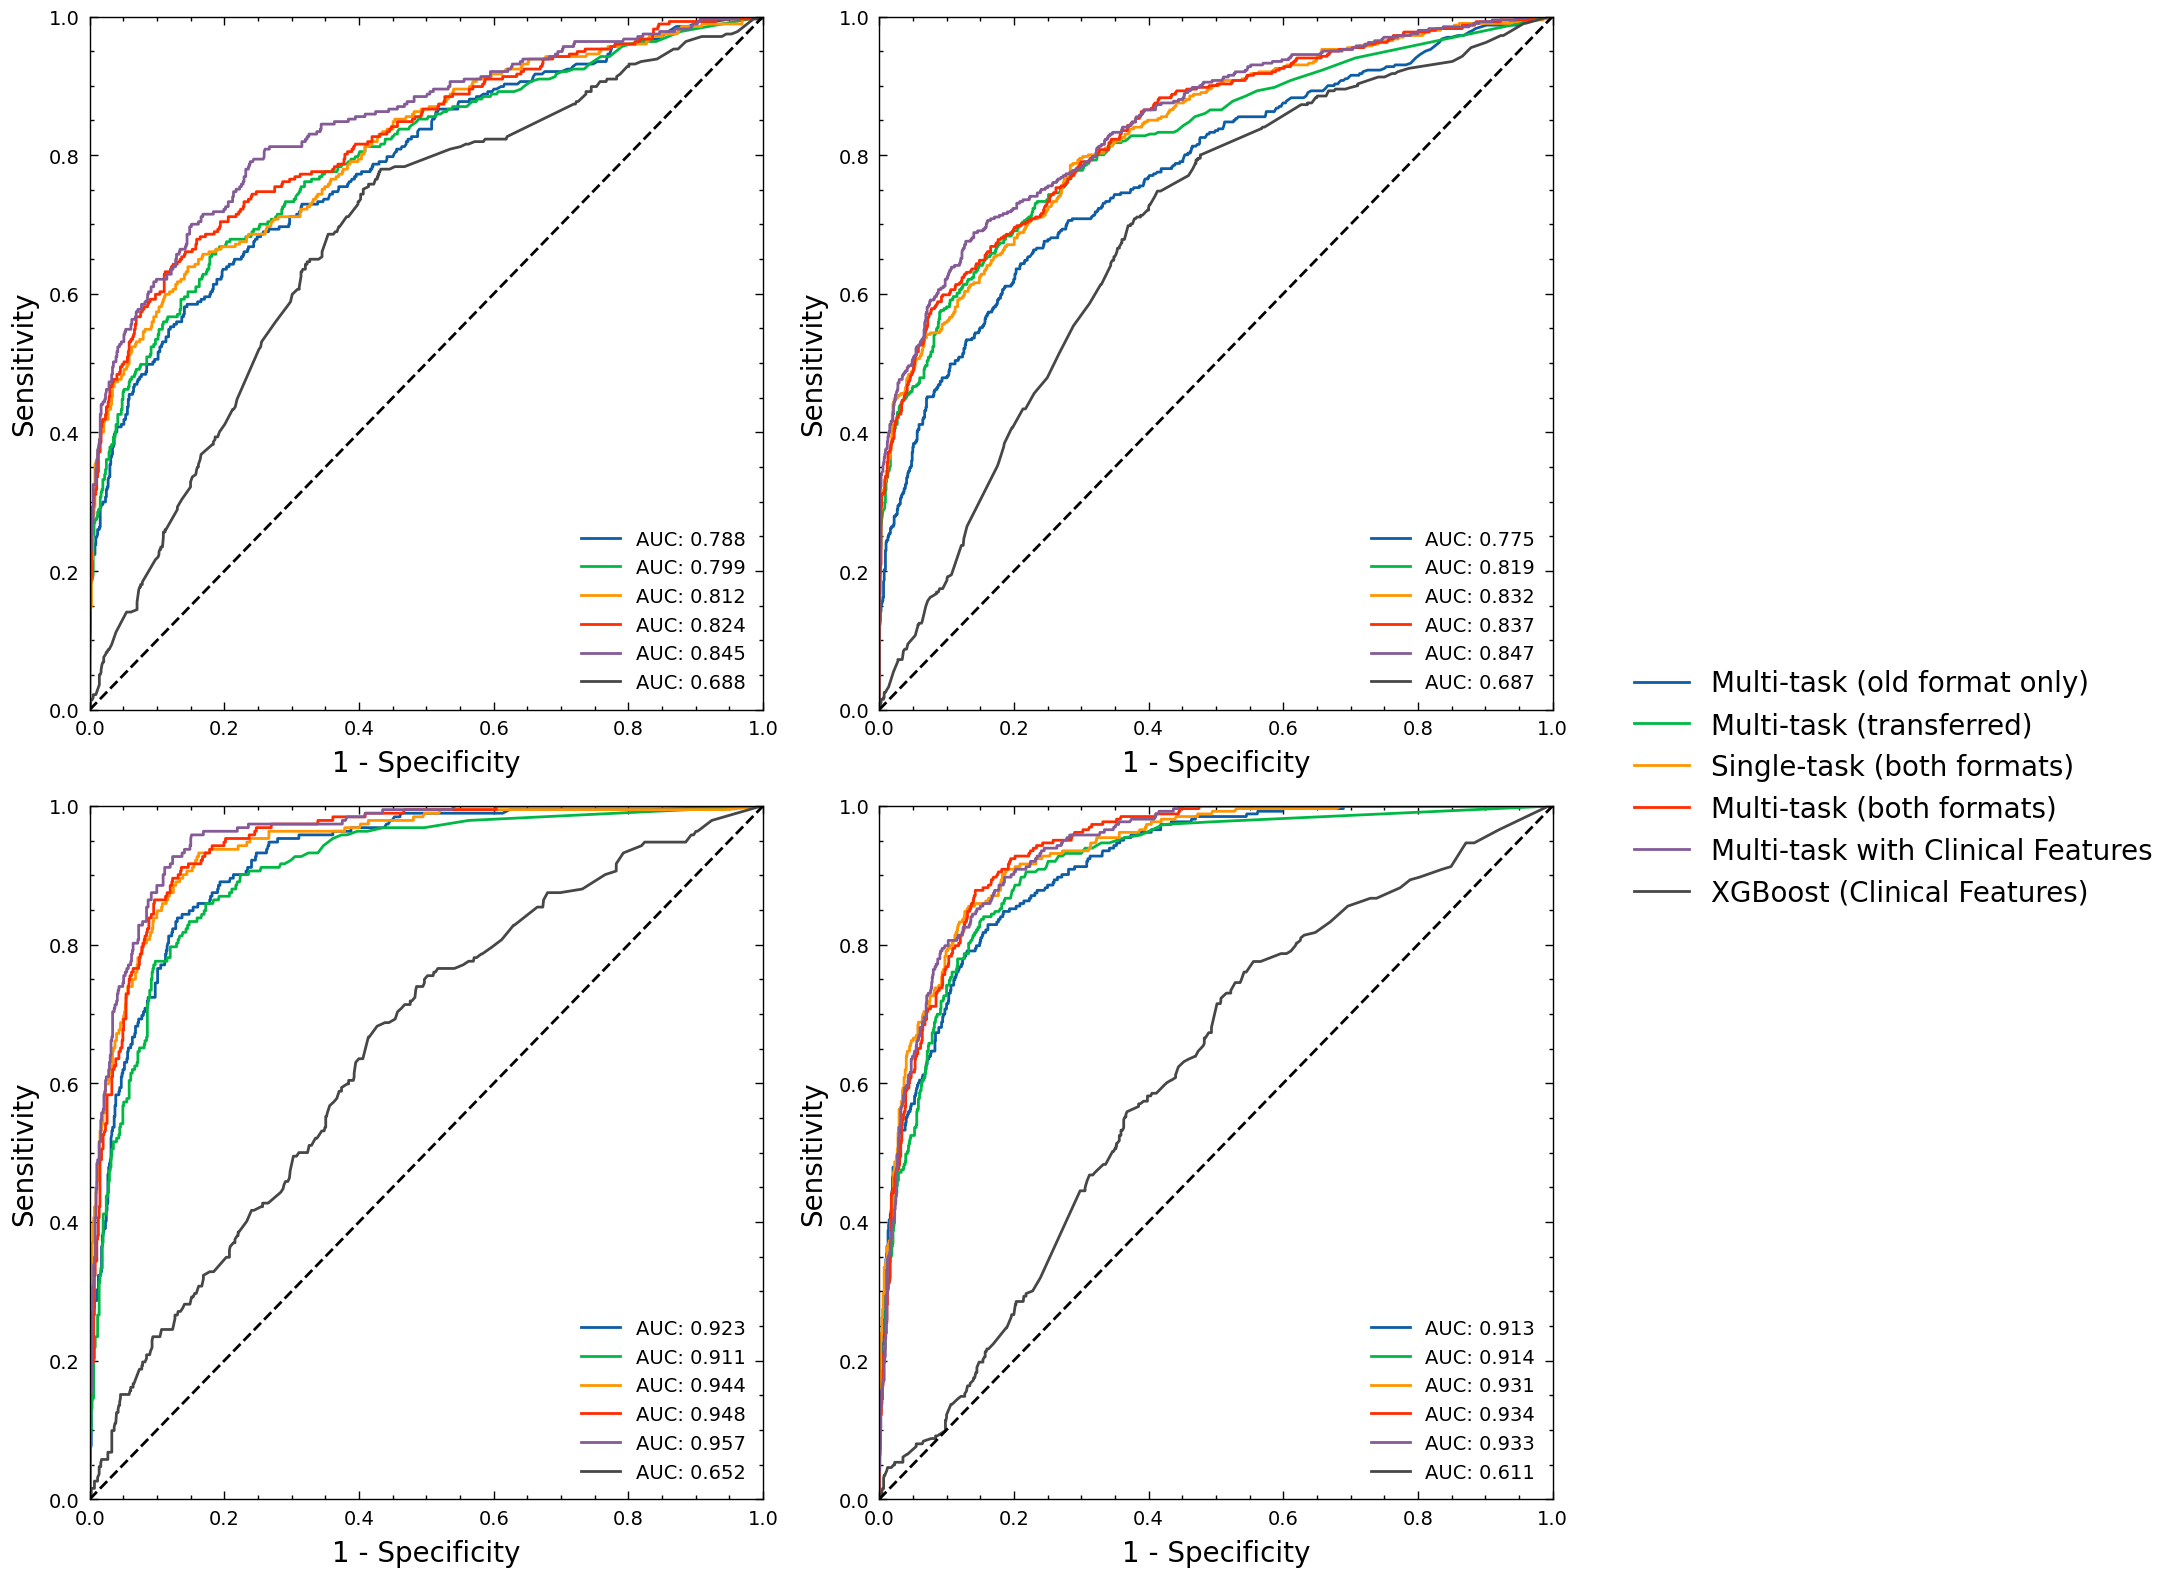

In [19]:
fig, axes  = plt.subplots(2, 2, figsize = (8,8))
threshold_list = np.arange(0, 1.01, 0.0001)


plot_model_curves(
    prediction_df_dict[("scar", "old_test")],
    subplot_object=axes[0, 0],
    threshold_list=threshold_list,
    )
plot_model_curves(
    prediction_df_dict[("scar", "new_test")],
    subplot_object=axes[0, 1],
    threshold_list=threshold_list,
)

plot_model_curves(
    prediction_df_dict[("lvef", "old_test")],
    subplot_object=axes[1, 0],
    threshold_list=threshold_list,
)
plot_model_curves(
    prediction_df_dict[("lvef", "new_test")],
    subplot_object=axes[1, 1],
    threshold_list=threshold_list,
)

legend_coordinate = get_legend_coordinate(fig, axes)
legend_list = list(rename_dict.values())

fig.legend(
    legend_list,
    loc="right",
    ncol=1,
    fontsize=10,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=legend_coordinate
    )
fig.tight_layout()

fig.savefig(
    op.join(PNG_FIGURE_SAVE_DIR, "Figure3_roc_curves.png"),
    transparent=False,
    dpi=300
    )

fig.savefig(
    op.join(SVG_FIGURE_SAVE_DIR, "Figure3_roc_curves.svg"),
    transparent=False,
    dpi=300
    )

In [9]:
def add_inverse_specificity_column(dataframe, specificity_column_name: str = "Specificity"):
    dataframe["1-Specificity"] = 1 - dataframe[specificity_column_name]
    return dataframe


scar_old_format_table = get_sensitivity_specificity_table(
    prediction_df_dict[("scar", "old_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task with Clinical Features",
)

scar_new_format_table = get_sensitivity_specificity_table(
    prediction_df_dict[("scar", "new_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task with Clinical Features",
)

lvef_old_format_table = get_sensitivity_specificity_table(
    prediction_df_dict[("lvef", "old_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task with Clinical Features",
)

lvef_new_format_table = get_sensitivity_specificity_table(
    prediction_df_dict[("lvef", "new_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task with Clinical Features",
)

scar_old_format_table = add_inverse_specificity_column(scar_old_format_table)
scar_new_format_table = add_inverse_specificity_column(scar_new_format_table)
lvef_old_format_table = add_inverse_specificity_column(lvef_old_format_table)
lvef_new_format_table = add_inverse_specificity_column(lvef_new_format_table)

scar_old_format_table.to_csv(op.join(TABLE_SAVE_DIR, "sensitivity_specificity_table_scar_old_format.csv"), index=False)
scar_new_format_table.to_csv(op.join(TABLE_SAVE_DIR, "sensitivity_specificity_table_scar_new_format.csv"), index=False)
lvef_old_format_table.to_csv(op.join(TABLE_SAVE_DIR, "sensitivity_specificity_table_lvef_old_format.csv"), index=False)
lvef_new_format_table.to_csv(op.join(TABLE_SAVE_DIR, "sensitivity_specificity_table_lvef_new_format.csv"), index=False)

### **Figure 3S**: Cardiologists' MS Sensitivity and Specificity curves

In [ ]:
def get_best_sensitivity_and_specificity_combination(sensitivity_list, specificity_list):
    """Get the best sensitivity and specificity combination.

    Args:
        sensitivity_list (list): List of sensitivity values.
        specificity_list (list): List of specificity values.

    Returns:
        best_sensitivity (float): Best sensitivity value.
        best_specificity (float): Best specificity value.
    """
    combined_values = np.array(sensitivity_list) + np.array(specificity_list)
    best_index = np.argmax(combined_values)
    best_sensitivity = sensitivity_list[best_index]
    best_specificity = specificity_list[best_index]
    return best_sensitivity, best_specificity

def add_best_sensitivity_and_specicificity(
    dataframe: pd.DataFrame,
    subplot_object,
    label_column_name: str = "true_label",
    predicted_proba_column_name: str = "predicted_proba",
    threshold_list = np.arange(0, 1.01, 0.01),
    title: str = "R1",
    x_coordinate: float = 1.2,
    y_coordinate: float = 0.5,
    color = "blue",
    **kwargs
):
    sensitivity_list, specificity_list = get_sensitivity_and_specificity_by_threshold(
        dataframe[label_column_name],
        dataframe[predicted_proba_column_name],
        threshold_list = threshold_list,
    )
    best_sensitivity, best_specificity = get_best_sensitivity_and_specificity_combination(sensitivity_list, specificity_list)

    subplot_object.text(x_coordinate, y_coordinate, f"{title}", fontsize=6, fontweight="bold", color=color)
    subplot_object.text(x_coordinate, y_coordinate - 0.05, f"Sensitivity: {best_sensitivity:.2f}", fontsize=6)
    subplot_object.text(x_coordinate, y_coordinate - 0.10, f"Specificity: {best_specificity:.2f}", fontsize=6)

In [ ]:
data_path = "resources/statistics/AI_ECG_prop_R1_R2.xlsx"

r1_name = "Experienced"
r2_name = "In-training"
label_column_name = "SCAR_CAD"

cardiologist_df = pd.read_excel(data_path)
cardiologist_df.rename(columns={"prob_ecg_cardio_scar_R1_Q": r1_name, "prob_ecg_cardio_scar_R2_Q": r2_name}, inplace=True)

cardiologist_df_1 = cardiologist_df[[r1_name, label_column_name]].dropna()
cardiologist_df_2 = cardiologist_df[[r2_name, label_column_name]].dropna()
cardiologist_df_all = cardiologist_df[[r1_name, r2_name, label_column_name]].dropna()

In [ ]:
fig, axes  = plt.subplots(1, 1, figsize = (4,4))
threshold_list = np.arange(0, 1.01, 0.01)

plot_model_curves(
    cardiologist_df_all,
    label_column_name = label_column_name,
    subplot_object=axes,
    threshold_list=threshold_list,
    model_name_in_legend=True,
)

add_best_sensitivity_and_specicificity(
    cardiologist_df_all,
    subplot_object=axes,
    label_column_name = label_column_name,
    predicted_proba_column_name = r1_name,
    threshold_list=threshold_list,
    title=r1_name,
    x_coordinate=1.05,
    y_coordinate=0.32,
    color=axes.lines[0].get_color(),
)

add_best_sensitivity_and_specicificity(
    cardiologist_df_all,
    subplot_object=axes,
    label_column_name = label_column_name,
    predicted_proba_column_name = r2_name,
    threshold_list=threshold_list,
    title=r2_name,
    x_coordinate=1.05,
    y_coordinate=0.12,
    color=axes.lines[1].get_color(),
)

fig.tight_layout()

fig.savefig(
    op.join(SAVE_DIR, "Figure3s_cardiologist_sensitivity_specificity_curve.png"),
    transparent=False,
    dpi=300
)

fig.savefig(
    op.join(SAVE_DIR, "Figure3s_cardiologist_sensitivity_specificity_curve.svg"),
    transparent=False,
    dpi=300
)

## **Figure 4**

In [ ]:
# %pip install statsmodels

In [10]:
from statsmodels.stats.proportion import proportion_confint

row_name_x_coordinate = -0.4
tpr_row_y_coordinate = -0.2
fpr_row_y_coordinate = -0.3
x_offset = -0.03

def get_tpr_and_fpr_by_threshold(
    label_list: list,
    predicted_proba_list: list,
    threshold_list = np.arange(0, 1.01, 0.01)
    ):
    """
    Get the true positive rate and false positive rate by threshold.
    Also finds the 95% confidence interval of the true positive rate and false positive rate by threshold.
    """

    tpr_list = []
    lower_tpr_list = []
    upper_tpr_list = []
    fpr_list = []
    lower_fpr_list = []
    upper_fpr_list = []

    for threshold in tqdm(threshold_list):
        predicted_list = []
        for proba in predicted_proba_list:
            prediction = (proba >= threshold)
            predicted_list.append(prediction)

        cm = confusion_matrix(label_list, predicted_list)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp+fn)
        lower_tpr, upper_tpr = proportion_confint(tp, tp+fn, alpha=0.05, method='normal')

        fpr = fp / (fp+tn)
        lower_fpr, upper_fpr = proportion_confint(fp, fp+tn, alpha=0.05, method='normal')
        tpr_list.append(tpr)
        lower_tpr_list.append(lower_tpr)
        upper_tpr_list.append(upper_tpr)

        fpr_list.append(fpr)
        lower_fpr_list.append(lower_fpr)
        upper_fpr_list.append(upper_fpr)
    return tpr_list, lower_tpr_list, upper_tpr_list, fpr_list, lower_fpr_list, upper_fpr_list

def add_tpr_fpr_labels_under_plot(
    dataframe: pd.DataFrame,
    subplot_object,
    label_column_name: str = "true_label",
    predicted_proba_column_name: str = "predicted_proba",
    row_name_x_coordinate = row_name_x_coordinate,
    tpr_row_y_coordinate = tpr_row_y_coordinate,
    fpr_row_y_coordinate = fpr_row_y_coordinate,
    x_offset = x_offset,
    # 0.1 step size for the label texts.
    threshold_list = np.arange(0, 1.01, 0.1),
    **kwargs
):
    tpr_list, _, _, fpr_list, _, _ = get_tpr_and_fpr_by_threshold(
        dataframe[label_column_name],
        dataframe[predicted_proba_column_name],
        threshold_list = threshold_list,
    )
    subplot_object.text(row_name_x_coordinate, tpr_row_y_coordinate, "True positive rate", fontsize=6, fontweight="bold")
    subplot_object.text(row_name_x_coordinate, fpr_row_y_coordinate, "False positive rate", fontsize=6, fontweight="bold")

    for threshold, tpr, fpr in zip(threshold_list, tpr_list, fpr_list):
        subplot_object.text(threshold + x_offset, tpr_row_y_coordinate, f"{tpr:.2f}", fontsize=6)
        subplot_object.text(threshold + x_offset, fpr_row_y_coordinate, f"{fpr:.2f}", fontsize=6)

# A function to plot the tpr and fpr by threshold.
def plot_tpr_fpr_by_threshold(
    dataframe,
    label_column_name: str = "true_label",
    predicted_proba_column_name: str = "predicted_proba",
    subplot_object = None,
    threshold_list: np.ndarray = np.arange(0, 1.01, 0.01),
    xlabel: str = "Probability Threshold",
    ylabel: str = "TPR/FPR Value",
    add_tpr_fpr_labels_kwargs: dict = {},
    ):

    tpr_list, lower_tpr_list, upper_tpr_list, fpr_list, lower_fpr_list, upper_fpr_list = get_tpr_and_fpr_by_threshold(
        dataframe[label_column_name],
        dataframe[predicted_proba_column_name],
        threshold_list = threshold_list
        )

    if not subplot_object:
        subplot_object = plt
    subplot_object.plot(threshold_list, tpr_list)
    subplot_object.fill_between(threshold_list, lower_tpr_list, upper_tpr_list, alpha=0.2, label='_nolegend_')

    subplot_object.plot(threshold_list, fpr_list)
    subplot_object.fill_between(threshold_list, lower_fpr_list, upper_fpr_list, alpha=0.2, label='_nolegend_')

    # Insert texts: True Positive Rate and False Positive Rate labels below the plot.
    if add_tpr_fpr_labels_kwargs:
        add_tpr_fpr_labels_under_plot(
            dataframe,
            subplot_object = subplot_object,
            label_column_name = label_column_name,
            predicted_proba_column_name = predicted_proba_column_name,
            **add_tpr_fpr_labels_kwargs
            )

    if subplot_object == plt:
        subplot_object.xlabel(xlabel, fontsize=10)
        subplot_object.ylabel(ylabel, fontsize=10)
        subplot_object.xlim(0, 1)
        subplot_object.ylim(0, 1)
        if add_tpr_fpr_labels_kwargs:
            subplot_object.xticks(tpr_fpr_text_label_threshold_list)
    else:
        subplot_object.set_xlabel(xlabel, fontsize=10)
        subplot_object.set_ylabel(ylabel, fontsize=10)
        subplot_object.set_xlim(0, 1)
        subplot_object.set_ylim(0, 1)
        if add_tpr_fpr_labels_kwargs:
            subplot_object.set_xticks(tpr_fpr_text_label_threshold_list)

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

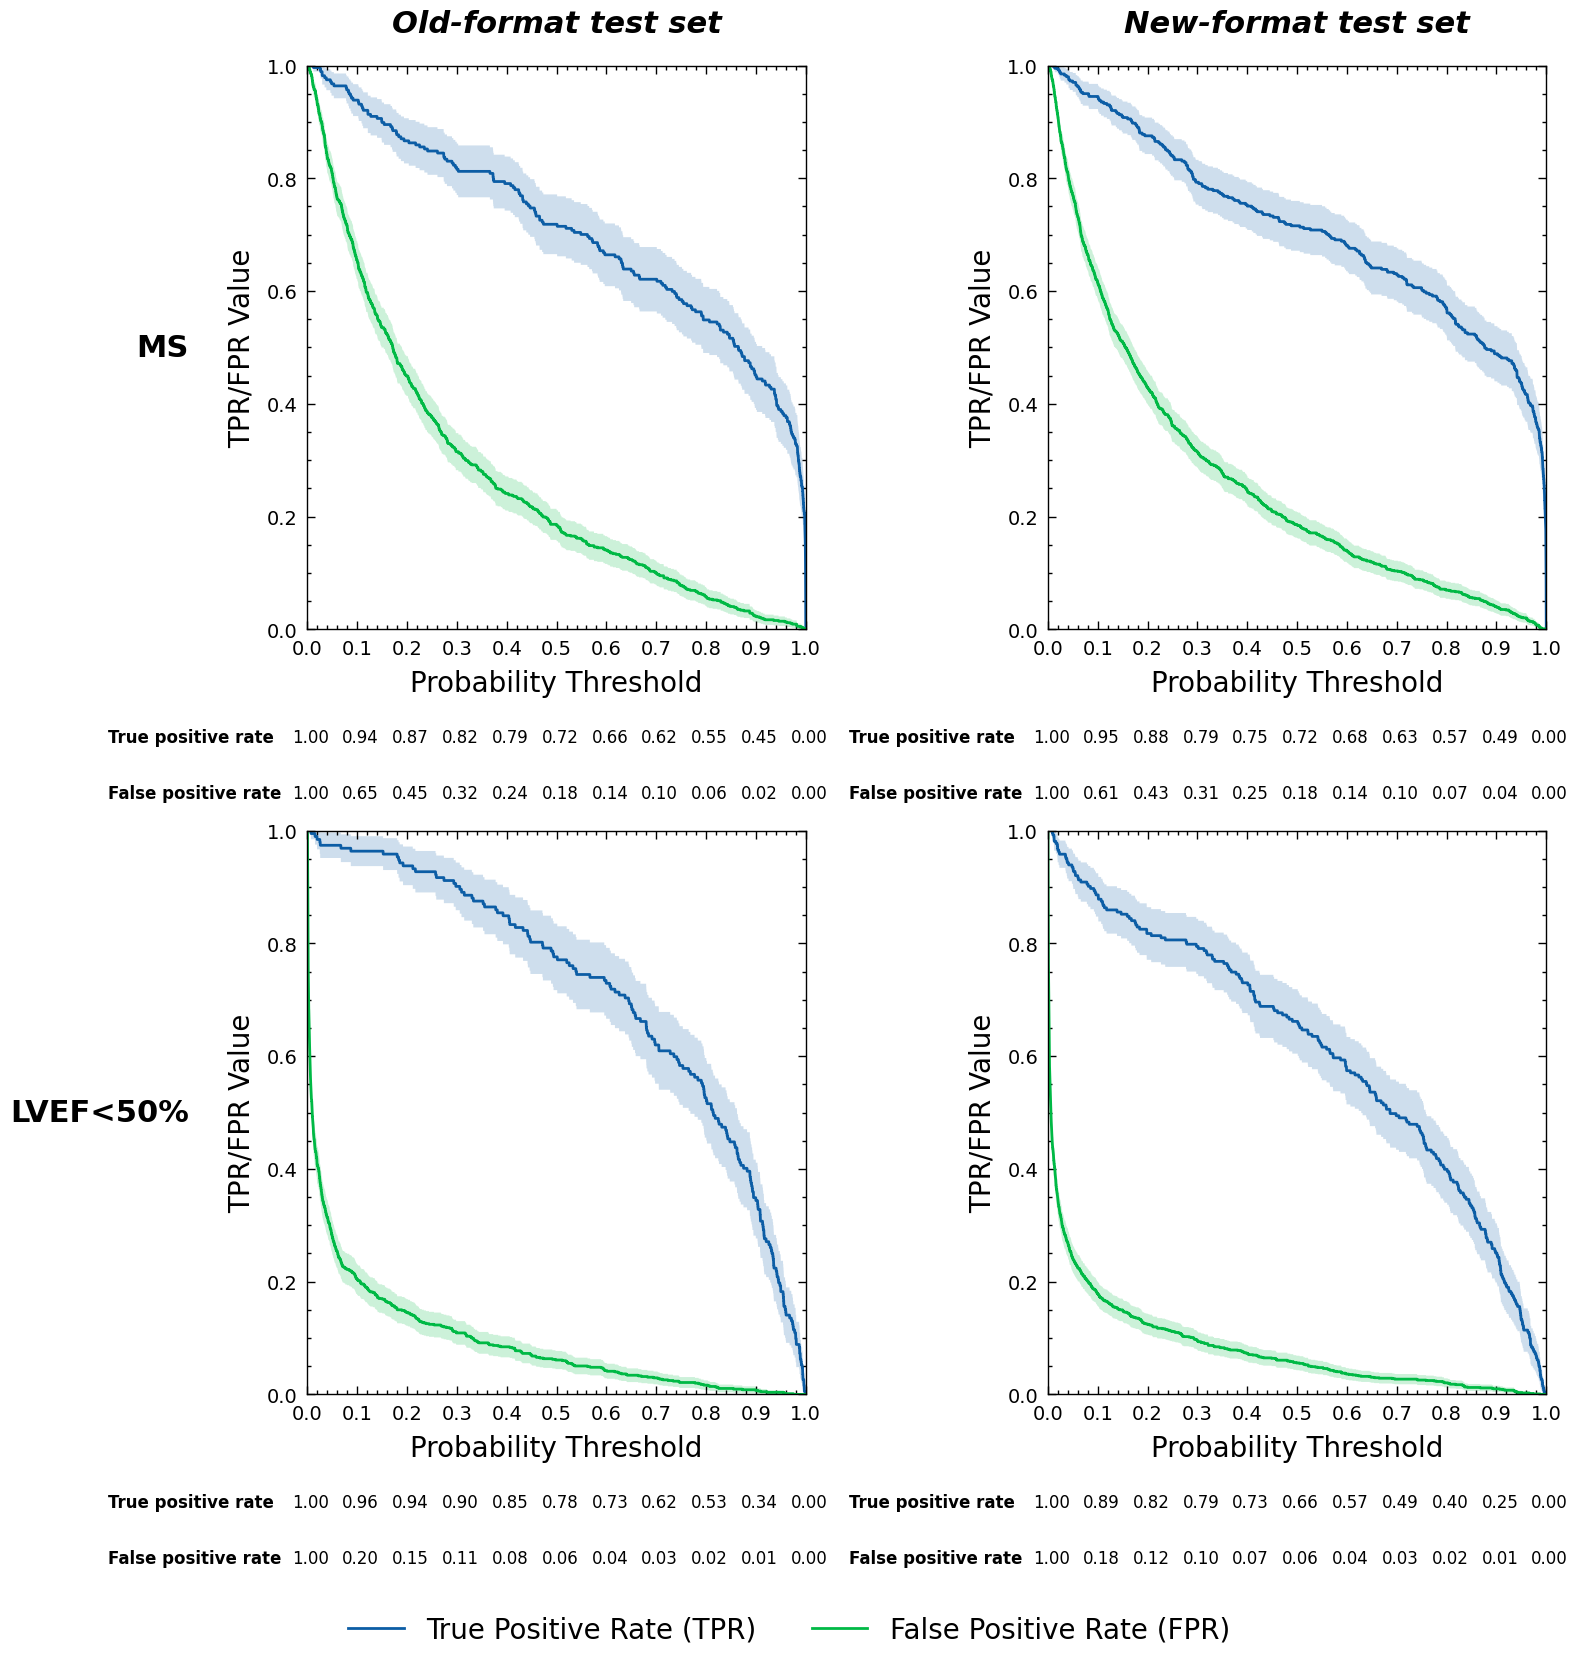

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
threshold_list = np.arange(0, 1.01, 0.0001)
tpr_fpr_text_label_threshold_list = np.arange(0, 1.01, 0.1)
target_model_column = "Multi-task with Clinical Features"

add_tpr_fpr_labels_kwargs = {
    "row_name_x_coordinate": -0.4,
    "tpr_row_y_coordinate": -0.2,
    "fpr_row_y_coordinate": -0.3,
    "x_offset": -0.03,
    "threshold_list": tpr_fpr_text_label_threshold_list,
}

plot_tpr_fpr_by_threshold(
    prediction_df_dict[("scar", "old_test")],
    predicted_proba_column_name=target_model_column,
    subplot_object=axes[0, 0],
    threshold_list=threshold_list,
    add_tpr_fpr_labels_kwargs=add_tpr_fpr_labels_kwargs,
)

axes[0, 0].set_title("Old-format test set", fontdict={"fontsize": 11, "fontweight": "bold", "style": "italic"}, pad=12)
axes[0, 0].annotate(
    "MS",
    xy=(0, 0.5),
    xytext=(-axes[0, 0].yaxis.labelpad - 10, 0),
    xycoords=axes[0, 0].yaxis.label,
    textcoords="offset points",
    size="11",
    ha="right",
    va="center",
    weight="bold",
)

plot_tpr_fpr_by_threshold(
    prediction_df_dict[("scar", "new_test")],
    predicted_proba_column_name=target_model_column,
    subplot_object=axes[0, 1],
    threshold_list=threshold_list,
    add_tpr_fpr_labels_kwargs=add_tpr_fpr_labels_kwargs,
)
axes[0, 1].set_title("New-format test set", fontdict={"fontsize": 11, "fontweight": "bold", "style": "italic"}, pad=12)
axes[1, 0].annotate(
    "LVEF<50%",
    xy=(0, 0.5),
    xytext=(-axes[1, 0].yaxis.labelpad - 10, 0),
    xycoords=axes[1, 0].yaxis.label,
    textcoords="offset points",
    size="11",
    ha="right",
    va="center",
    weight="bold",
)

plot_tpr_fpr_by_threshold(
    prediction_df_dict[("lvef", "old_test")],
    predicted_proba_column_name=target_model_column,
    subplot_object=axes[1, 0],
    threshold_list=threshold_list,
    add_tpr_fpr_labels_kwargs=add_tpr_fpr_labels_kwargs,
)
plot_tpr_fpr_by_threshold(
    prediction_df_dict[("lvef", "new_test")],
    predicted_proba_column_name=target_model_column,
    subplot_object=axes[1, 1],
    threshold_list=threshold_list,
    add_tpr_fpr_labels_kwargs=add_tpr_fpr_labels_kwargs,
)

legend_coordinate = get_legend_coordinate(fig, axes, add_x1=0, add_y1= -0.02)
legend_list = ["True Positive Rate (TPR)", "False Positive Rate (FPR)"]

fig.legend(
    legend_list, loc="upper center", ncol=2, fontsize=10, fancybox=True, shadow=True, bbox_to_anchor=legend_coordinate
)
fig.tight_layout()

fig.savefig(
    op.join(PNG_FIGURE_SAVE_DIR, "Figure4_tpr_fpr_curve_multitask_clinical.png"),
    transparent=False,
    dpi=300
    )

fig.savefig(
    op.join(SVG_FIGURE_SAVE_DIR, "Figure4_tpr_fpr_curve_multitask_clinical.svg"),
    transparent=False,
    dpi=300
    )

### **Figure 4S**: ROC Curves at EF 40%

In [20]:
folder_dir = "../resources/prediction_probabilities/"

task_list = ["lvef"]
target_test_format_list = ["old_test_sensitivity", "new_test_sensitivity"]

prediction_path_dict = {}
for task in task_list:
    for target_test_format in target_test_format_list:
        prediction_path_dict[task, target_test_format] = op.join(folder_dir, f"{task}_probabilities_{target_test_format}.csv")

# Load the predicted dataframes.
sensitivity_prediction_df_dict = {key: pd.read_csv(path) for key, path in prediction_path_dict.items()}
sensitivity_prediction_df_dict = {key: prediction_df.rename(columns=rename_dict) for key, prediction_df in sensitivity_prediction_df_dict.items()}

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

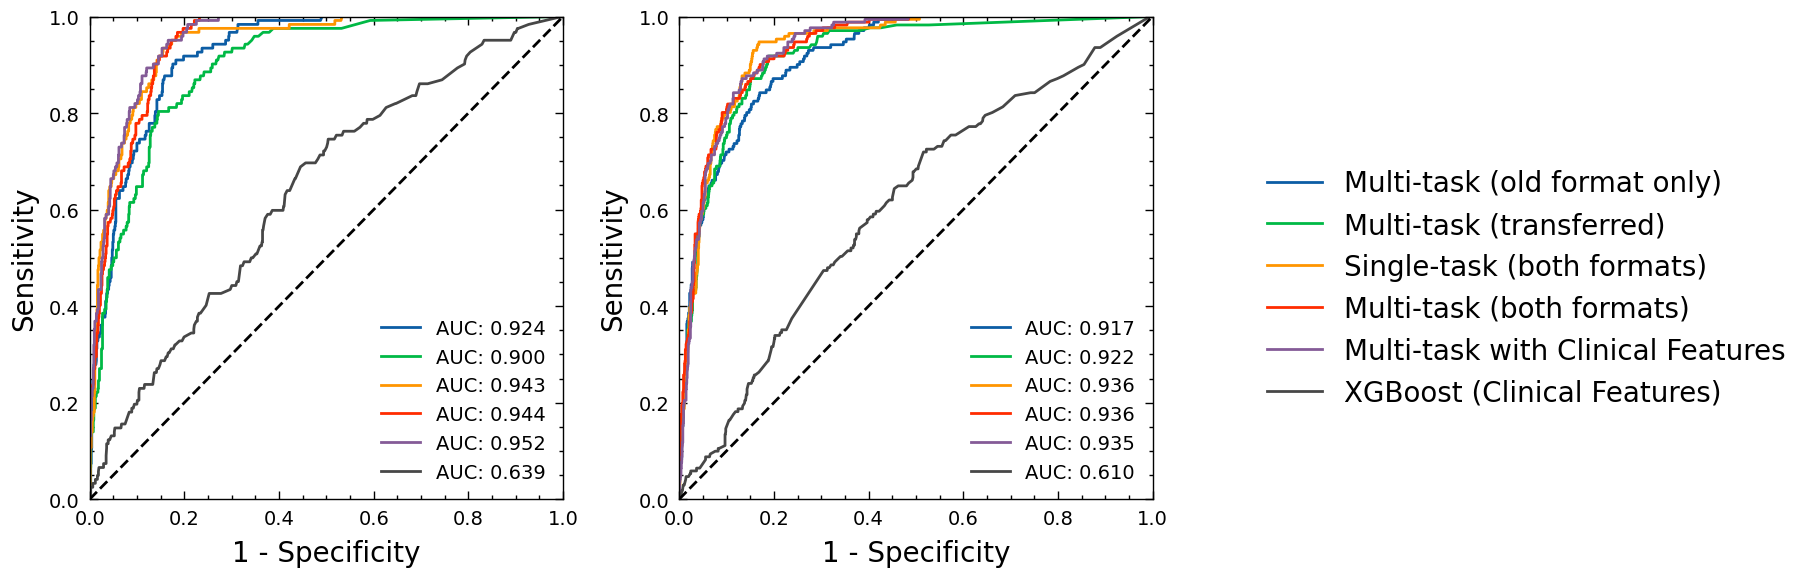

In [21]:
fig, axes  = plt.subplots(1, 2, figsize = (6, 3))
threshold_list = np.arange(0, 1.01, 0.0001)


plot_model_curves(
    sensitivity_prediction_df_dict[("lvef", "old_test_sensitivity")],
    subplot_object=axes[0],
    threshold_list=threshold_list,
)
plot_model_curves(
    sensitivity_prediction_df_dict[("lvef", "new_test_sensitivity")],
    subplot_object=axes[1],
    threshold_list=threshold_list,
)

legend_coordinate = get_legend_coordinate(fig, axes, add_x1 = 1.5,)
legend_list = list(rename_dict.values())

fig.legend(
    legend_list,
    loc="right",
    ncol=1,
    fontsize=10,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=legend_coordinate
    )
fig.tight_layout()

fig.savefig(
    op.join(PNG_FIGURE_SAVE_DIR, "Figure4s_roc_curves_ef40.png"),
    transparent=False,
    dpi=300
    )

fig.savefig(
    op.join(SVG_FIGURE_SAVE_DIR, "Figure4s_roc_curves_ef40.svg"),
    transparent=False,
    dpi=300
    )

## **Figure 5**

In [14]:
def plot_model_output_distribution(
    dataframe: pd.DataFrame,
    label_column_name: str = "true_label",
    predicted_proba_column_name: str = "predicted_proba",
    subplot_object = None,
    num_bins: int = 40,
    alpha: float = 0.5,
    label_name_map: dict = {0 : "Normal", 1: "Abnormal"},
    ylabel: str = "Frequency",
    include_legend: bool = False,
    ):

    negative_label_dataframe = dataframe[dataframe[label_column_name] == 0]
    positive_label_dataframe = dataframe[dataframe[label_column_name] == 1]

    subplot_object.hist(
        list(negative_label_dataframe[predicted_proba_column_name]),
        bins=num_bins,
        alpha=alpha,
        label=label_name_map[0],
        weights = np.ones_like(negative_label_dataframe.index) / len(negative_label_dataframe.index),
        color="deepskyblue",
        )
    subplot_object.hist(
        list(positive_label_dataframe[predicted_proba_column_name]),
        bins=num_bins,
        alpha=alpha,
        label=label_name_map[1],
        weights=np.ones_like(positive_label_dataframe.index) / len(positive_label_dataframe.index),
        color="r",
        )

    subplot_object.set_xlabel(f"Probability of {label_name_map[1]}", fontsize=8)
    subplot_object.set_ylabel(ylabel, fontsize=8)
    subplot_object.set_xticks(np.arange(0, 1.01, 0.2), fontsize=6)
    subplot_object.set_yticks(np.arange(0, 1.01, 0.2), fontsize=6)
    subplot_object.set_xlim(0, 1)
    subplot_object.set_ylim(0, 1)
    if include_legend:
        subplot_object.legend(loc="center right", fontsize=8, fancybox=True, shadow=True)

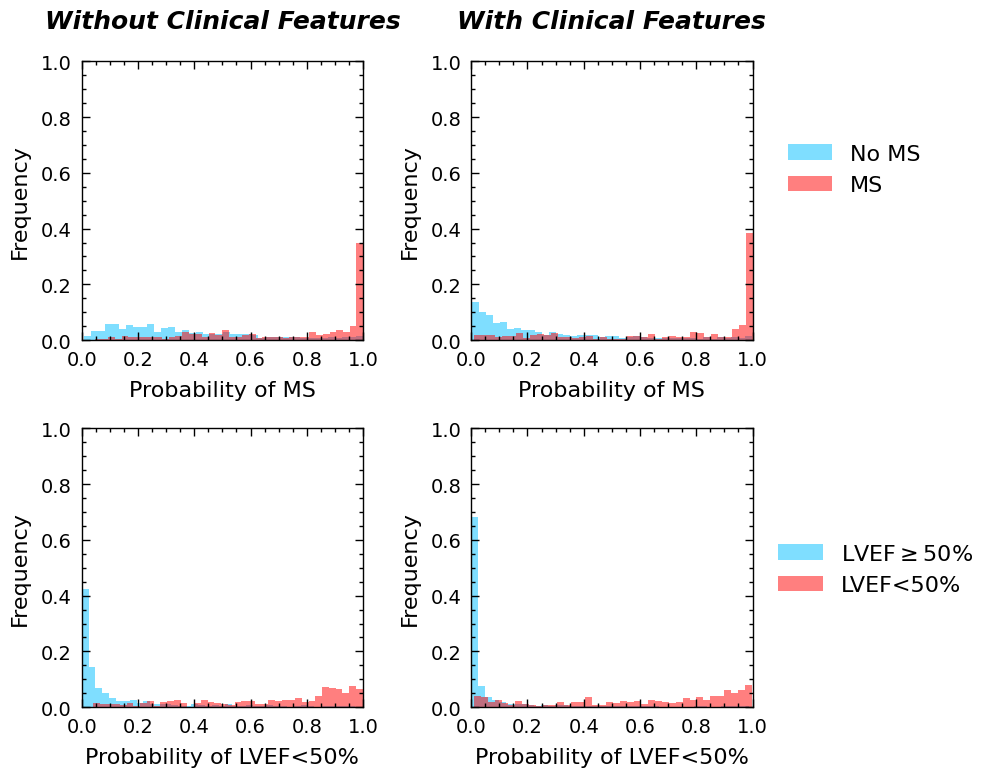

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

scar_label_name_map = {0: "No MS", 1: "MS"}
lvef_label_name_map = {0: "LVEF" + r"$\geq$" + "50" + r"$\%$", 1: "LVEF<50%"}


plot_model_output_distribution(
    prediction_df_dict[("scar", "new_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task (both formats)",
    subplot_object=axes[0, 0],
    label_name_map=scar_label_name_map,
)
axes[0, 0].set_title(
    "Without Clinical Features", fontdict={"fontsize": 9, "fontweight": "bold", "style": "italic"}, pad=12
)

plot_model_output_distribution(
    prediction_df_dict[("scar", "new_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task with Clinical Features",
    subplot_object=axes[0, 1],
    label_name_map=scar_label_name_map,
)
axes[0, 1].set_title(
    "With Clinical Features", fontdict={"fontsize": 9, "fontweight": "bold", "style": "italic"}, pad=12
)

plot_model_output_distribution(
    prediction_df_dict[("lvef", "new_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task (both formats)",
    subplot_object=axes[1, 0],
    label_name_map=lvef_label_name_map,
)
plot_model_output_distribution(
    prediction_df_dict[("lvef", "new_test")],
    label_column_name="true_label",
    predicted_proba_column_name="Multi-task with Clinical Features",
    subplot_object=axes[1, 1],
    label_name_map=lvef_label_name_map,
)

legend_coordinate = get_legend_coordinate(fig, axes, add_x1=1.16, add_y1=0.80)
fig.legend(
    scar_label_name_map.values(),
    loc="upper right",
    ncol=1,
    fontsize=8,
    borderaxespad=0.1,
    bbox_to_anchor=legend_coordinate,
)

legend_coordinate = get_legend_coordinate(fig, axes, add_x1=1.22, add_y1=0.30)
fig.legend(
    lvef_label_name_map.values(),
    loc="upper right",
    ncol=1,
    fontsize=8,
    borderaxespad=0.1,
    bbox_to_anchor=legend_coordinate,
)

fig.tight_layout()

fig.savefig(
    op.join(PNG_FIGURE_SAVE_DIR, "Figure5_output_probs.png"),
    transparent=False,
    dpi=300
    )

fig.savefig(
    op.join(SVG_FIGURE_SAVE_DIR, "Figure5_output_probs.svg"),
    transparent=False,
    dpi=300
    )

## **Performance Tables**

In [36]:
xgboost_scar_model_path = "../trained_models/xgboost-clinical/scar_model"
xgboost_lvef_model_path = "../trained_models/xgboost-clinical/lvef_model"
multitask_old_format_model_path = "../trained_models/multi-task-old-format/resnet34d_384_LVEF50"
multitask_transferred_model_path = "../trained_models/multi-task-transferred/resnet34d_384_LVEF50"
singletask_scar_model_path = "../trained_models/single-task-scar/resnet34d_384_LVEF50"
singletask_lvef_model_path = "../trained_models/single-task-lvef/resnet34d_384_LVEF50"
multitask_model_path = "../trained_models/multi-task/resnet34d_384_LVEF50"
multitask_clinical_model_path = "../trained_models/multi-task-clinical/resnet34d_384_LVEF50_birnn_dim512"

scar_model_name_to_dir_map_dict = {
    "XGBoost (Clinical Features)": xgboost_scar_model_path,
    "Multi-task (old format)": multitask_old_format_model_path,
    "Multi-task (transferred)": multitask_transferred_model_path,
    "Single-task (both formats)": singletask_scar_model_path,
    "Multi-task (both formats)": multitask_model_path,
    "Multi-task with Clinical Features": multitask_clinical_model_path,
}

lvef_model_name_to_dir_map_dict = {
    "XGBoost (Clinical Features)": xgboost_lvef_model_path,
    "Multi-task (old format)": multitask_old_format_model_path,
    "Multi-task (transferred)": multitask_transferred_model_path,
    "Single-task (both formats)": singletask_lvef_model_path,
    "Multi-task (both formats)": multitask_model_path,
    "Multi-task with Clinical Features": multitask_clinical_model_path,
}

model_name_to_dir_map_dict = {
    "scar": scar_model_name_to_dir_map_dict,
    "lvef": lvef_model_name_to_dir_map_dict,
}

In [41]:
glob(op.join("../resources/statistics/scar_baseline_metrics/*"))

['../resources/statistics/scar_baseline_metrics\\new_test.csv',
 '../resources/statistics/scar_baseline_metrics\\new_test_sensitivity.csv',
 '../resources/statistics/scar_baseline_metrics\\old_test.csv',
 '../resources/statistics/scar_baseline_metrics\\old_test_sensitivity.csv']

In [40]:
from glob import glob

pd.read_csv(glob(op.join("../resources/statistics/scar_baseline_metrics/*"))[0])

,Unnamed: 0,0
0,Accuracy,0.729602
1,Specificity,1.000000
2,Sensitivity,NaN
3,F1,0.615540
4,AUC,NaN
5,FPR,0.000000
6,FNR,NaN


In [44]:

from typing import Dict
def get_model_metrics(
    model_name_to_dir_map_dict: Dict[str, str],
    baseline_metric_dir: str,
    task: str,
    test_set_suffix: str,
    metrics_csv_path_pattern: str = "metrics_{}.csv",
    save_path: str = None,
    ) -> pd.DataFrame:
    metrics_csv_filename = metrics_csv_path_pattern.format(test_set_suffix)
    baseline_metrics_csv_path = op.join(baseline_metric_dir, f"{test_set_suffix}.csv")
    baseline_metric_df = pd.read_csv(baseline_metrics_csv_path)
    baseline_metric_df.rename(columns={"0": task}, inplace=True)

    model_name_to_metrics_df_dict = {"Baseline": baseline_metric_df[task]}
    for model_name, model_dir in model_name_to_dir_map_dict.items():
        metrics_csv_path = op.join(model_dir, metrics_csv_filename)
        metrics_df = pd.read_csv(metrics_csv_path)
        if task not in metrics_df.columns:
            metrics_df.rename(columns={"0": task}, inplace=True)
        model_name_to_metrics_df_dict[model_name] = metrics_df[task]
    combined_metrics_df = pd.DataFrame(model_name_to_metrics_df_dict).T
    combined_metrics_df.columns = list(metrics_df['Unnamed: 0'])
    # Scale & Round.
    combined_metrics_df = combined_metrics_df * 100
    combined_metrics_df = combined_metrics_df.round(2)

    if save_path:
        combined_metrics_df.to_csv(save_path, index=True)
    return combined_metrics_df

In [45]:
METRICS_TABLE_SAVE_PATH = "../resources/tables/metrics_table"
os.makedirs(METRICS_TABLE_SAVE_PATH, exist_ok=True)

In [47]:
baseline_metric_dir_pattern = "../resources/statistics/{task}_baseline_metrics"

for task in ["scar", "lvef"]:
    for test_set_suffix in ["old_test", "new_test"]:
        save_path = op.join(METRICS_TABLE_SAVE_PATH, f"{task}_{test_set_suffix}.csv")
        get_model_metrics(
            model_name_to_dir_map_dict[task],
            baseline_metric_dir=baseline_metric_dir_pattern.format(task=task),
            task = task,
            test_set_suffix = test_set_suffix,
            save_path = save_path,
            )